In [1]:
import pyphs as phs
import sympy as sy
import numpy as np
import os

import datetime
import pickle
import sympy as sy
import matplotlib.pyplot as plt
import h5py
sy.init_printing()

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

PPTY_PHY_PARAMS = {"positive": True, "real" : True }                            
PPTY_STATE_VAR  = {"real" : True }

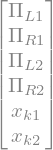

In [2]:
Ns = 2  # Number of subsystems


Ne = 3 # N of state per subsys
N_lambda = Ns-1 # constraints
Nx = Ns * Ne     # total N of states
Nx

piL_vec  = sy.symbols('Pi_L1:{}'.format(Ns+1), **PPTY_STATE_VAR)
piR_vec  = sy.symbols('Pi_R1:{}'.format(Ns+1), **PPTY_STATE_VAR)
xk_vec   = sy.symbols('x_k1:{}'.format(Ns+1), **PPTY_STATE_VAR)

mL_vec   = sy.symbols('m_L1:{}'.format(Ns+1), **PPTY_PHY_PARAMS)
mR_vec   = sy.symbols('m_R1:{}'.format(Ns+1), **PPTY_PHY_PARAMS)
k_vec    = sy.symbols('k_1:{}'.format(Ns+1), **PPTY_PHY_PARAMS)

params = mL_vec + mR_vec + k_vec

X = []
for i in range(Ns):
    X.append(piL_vec[i])
    X.append(piR_vec[i])
X += list(xk_vec)
X = sy.Matrix(X)
X

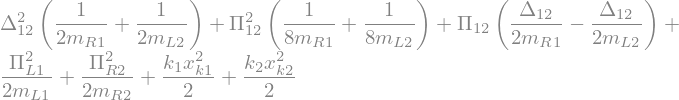

In [3]:
bT = sy.zeros(N_lambda, Nx)
for i in range(N_lambda):
    bT[i, 1+2*i] = 1 
    bT[i, 2+i*2] = -1
b = bT.T

annul_b = sy.zeros(Nx-N_lambda,Nx)

annul_b[0,0] = 1
annul_b[Ns::, Ns + N_lambda::] = sy.eye(Ns+1)
for i in range(1,N_lambda+1):
    annul_b[i, 2*i-1] = 1 
    annul_b[i, 2*i] = 1

M = sy.zeros(Nx, Nx)
M[0:Nx-N_lambda,::] = annul_b
M[Nx-N_lambda::, ::] = (bT*b).inv()*bT

Z = M*X
for i in range(N_lambda):
    Z[i+1] = sy.symbols('Pi_{0}{1}'.format(i+1,i+2), **PPTY_STATE_VAR)
for i in range(N_lambda):
    Z[Nx-N_lambda+i] = sy.symbols('Delta_{}'.format(10*(i+1) + (i+2)))
Z.T

# We are in a linear configuration for now
Q = sy.zeros(Nx)
for i in range(Ns):
    Q[2*i, 2*i] = 1/mL_vec[i]
    Q[2*i+1, 2*i+1] = 1/mR_vec[i]
    Q[i + 2*Ns, i + 2*Ns] = k_vec[i]
HX = sy.Rational(1,2) * X.T * Q * X
HX[0]

Minv = M.inv()
QZ = Minv.T * Q * Minv
QZ

HZ = sy.Rational(1,2) * Z.T * QZ * Z
HZ = HZ[0].expand().collect(Z)
HZ

'Find'

'such as: '

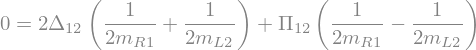

In [4]:
cstr_states = Z[Nx-N_lambda::]

cstr_eq = []
display("Find", cstr_states, "such as: ")
for i in range(N_lambda):
    cstr_eq.append(sy.Eq(0, HZ.diff(cstr_states[i])))
    display(cstr_eq[i])

## Interconnexion matrix

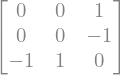

In [5]:
Jxi = sy.Matrix([[0,0,1],[0,0,-1],[-1,1,0]])
Jxi

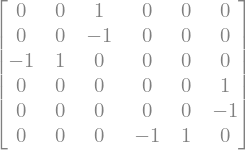

In [6]:
Jtot = sy.zeros(Nx)
for i in range(Ns):
    Jtot[3*i:3*i+Ne, 3*i:3*i+Ne] = Jxi
Jtot

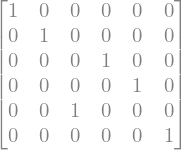

In [7]:
# permutation matrix: re-arranging Jxx to match X
P = sy.SparseMatrix(sy.zeros(Nx))

for i in range(Ns):
    # nu_L/ nu_R
    P[2*i, Ne*i]         = 1
    P[2*i+1, Ne*i+1]     = 1
    # Piy
    P[2*Ns+i, Ne*i+2] = 1
P

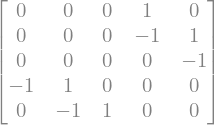

In [8]:
Jxx = M*P*Jtot*P.T*M.T
Jxx = Jxx[0:Nx-N_lambda, 0:Nx-N_lambda]
Jxx

## Building RHS

In [9]:
Z1 = sy.Matrix(Z[0:Nx-N_lambda])
Z2 = sy.Matrix(Z[Nx-N_lambda::])
display(Z1.T, Z2.T)

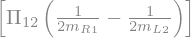

In [10]:
QZ12 = QZ[(Nx-N_lambda)::, 0:(Nx-N_lambda)]
QZ11 = QZ[0:(Nx-N_lambda), 0:(Nx-N_lambda)]
RHS = QZ12 * sy.Matrix(Z1)
RHS

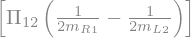

In [11]:
QZ12 = QZ[(Nx-N_lambda)::, 0:(Nx-N_lambda)]
RHS = QZ12 * Z1
display(RHS)

In [12]:
o_label = []
for ind in range(1, N_lambda+1):
    str_symb = 'RHS_' + str(ind)        
    symb = sy.symbols(str_symb, **PPTY_STATE_VAR)
    o_label.append(symb)
o_label

In [13]:
QZ22 = QZ[Nx-N_lambda::, Nx-N_lambda::]
QZ22

## Building Core

In [14]:
label = 'FPUT'
core = phs.Core(label=label)

Storage components

In [15]:
core.add_storages(list(Z1), HZ)
core.set_Jxx(Jxx)

Observers

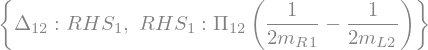

In [16]:
observers_dict = {}
for i in range(N_lambda):
    observers_dict[o_label[i]] = RHS[i]
    
for i in range(N_lambda):
    observers_dict[Z2[i]] = o_label[i]
    
core.add_observer(observers_dict)

display(core.observers)

Subs

In [17]:
subs = {}
for symb in params:
    subs[symb] = 1

subs[mR_vec[0]] = 1
subs[mR_vec[1]] = 1000
#subs[mR_vec[2]] = 1
#subs[mR_vec[3]] = 100

subs[mL_vec[0]] = 1
subs[mL_vec[1]] = 1000
#subs[mL_vec[2]] = 1
#subs[mL_vec[3]] = 100

subs[k_vec[0]]  = 1
subs[k_vec[1]]  = 10000
#subs[k_vec[2]]  = 100
#subs[k_vec[2]]  = 10000

display(subs)

core.subs.update(subs)

In [18]:
inits = {'x' : [1.0 for i in range(len(core.x))]}
ind = 2*Ns - N_lambda + 1
ind = 0
display(core.x[ind])
inits['x'][ind] = 0.1

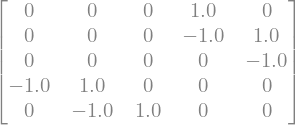

In [19]:
core.Jxx()

In [20]:
config = {'fs'   : 1e3, # sample rate (Hz)
          'path' : os.path.join(os.getcwd(), '03_data'), # folder for output results/build
          'lang' : 'c++',
          'cmake': r'cmake',
          'grad' : 'discret',
          'maxit': 10,
          'pbar' : False,
          'split': False,
          'timer': True,
          'epsdg': np.power(np.finfo(np.float64).eps, 0.5),
          'eps'  : np.finfo(np.float64).eps,
         }

simu = core.to_simulation(
                          config, 
                          erase = True,
                          inits = inits
                          )

Build method FPUT...
    Init Method...
    Build numerical structure...
    Init update actions...
    Init arguments...
        Build x
        Build dx
        Build w
        Build u
        Build p
        Build vnl
        Build o
    Init functions...
        Build ud_o
        Build z
        Build dxH
        Build Gnl
        Build jacGnlnl
        Build y
Prepare method FPUT for C++ generation...
    Init value for x
[0.100000000000000, 1.00000000000000, 1.00000000000000, 1.00000000000000, 1.00000000000000]
    Init value for dx
[0, 0, 0, 0, 0]
    Init value for ud_x
    Init value for o
[0, 0]
    Init value for ud_o
[0.499500000000000, 0]
    Init value for Gnl
[-1.00000000000000, -9999.00000000000, 10000.0000000000, -0.150250000000000, 0.249250000000000]
    Init value for Fnl
    Init value for res_Fnl
    Init value for save_Fnl
    Init value for jacGnlnl
    Init value for jacFnl
    Init value for ijacFnl
    Init value for vnl
[0, 0, 0, 0, 0]
    Init value for ud_

In [21]:
import modify_core_solver as modifs
from importlib import reload  
reload(modifs)
folder_path_in = os.path.join(config['path'],label.lower(), 'src')
modifs.insert_solver(folder_path_in, Ns)

In [22]:
tmax = 1.
Nit = int(tmax*config['fs'])
t_vec = np.linspace(0, tmax, int(Nit))


print('Build de la simulation à {0}'.format(datetime.datetime.now()))
simu.init(
        nt    = Nit,
        )
print('Simulation démarée à {0}'.format(datetime.datetime.now()))
simu.process()
print('Simulation finie à {0}'.format(datetime.datetime.now()))

Build de la simulation à 2020-07-10 16:16:35.428196
Simulation démarée à 2020-07-10 16:16:35.441666
Simulation: Process...
-- The CXX compiler identification is GNU 10.1.0

-- Check for working CXX compiler: /usr/bin/c++

-- Check for working CXX compiler: /usr/bin/c++ - works

-- Detecting CXX compiler ABI info

-- Detecting CXX compiler ABI info - done

-- Detecting CXX compile features

-- Detecting CXX compile features - done

-- HDF5: Using hdf5 compiler wrapper to determine CXX configuration

-- Found HDF5: /usr/lib/libhdf5_cpp.so;/usr/lib/libhdf5.so;/usr/lib/libsz.so;/usr/lib/libz.so;/usr/lib/libdl.so;/usr/lib/libm.so (found version "1.12.0") found components: HL CXX 

-- Configuring done

-- Generating done

-- Build files have been written to: /home/victorw/ownCloud/IRCAM/03_DOCS/38_FPUT_problem_DAE/02_python/02_numerical_exp/03_data/fput/build

Scanning dependencies of target FPUT

[ 25%] Building CXX object CMakeFiles/FPUT.dir/src/simu.cpp.o

[ 50%] Building CXX object CMake

In [23]:
# Date, heure etc...
timedate_now = datetime.datetime.now()
month  = timedate_now.month
day    = timedate_now.day
hour   = timedate_now.hour
minute = timedate_now.minute
date_now = [str(month).zfill(2), str(day).zfill(2), str(hour).zfill(2), str(minute).zfill(2)]

filename = '03_data/simu.{0}_{1}.{2}_{3}.h5'.format(*date_now)
fid      = h5py.File(filename, 'x')
dt       = h5py.string_dtype()

# Creating groups
data_simu     = fid.create_group('data_simu')
metadata      = fid.create_group('metadata')
model         = fid.create_group('model')
fid.flush()

# Saving signals
data = np.array( list(simu.data.x())     , dtype=np.float64).squeeze()
data_simu.create_dataset("x", data=data)

data = np.array( list(simu.data.dx())    , dtype=np.float64).squeeze()
data_simu.create_dataset("dx", data=data)

data = np.array( list(simu.data.dxH())   , dtype=np.float64).squeeze()
data_simu.create_dataset("dxH", data=data)

data = np.array( list(simu.data.dtx())   , dtype=np.float64).squeeze()
data_simu.create_dataset("dtx", data=data)


# time vector
data = t_vec
data_simu.create_dataset("t", data=data)

data

data = inits['x']
data_simu.create_dataset("init_X", data=data)


subs = subs
place = model.create_group("subs")

for key, val in subs.items():
    place.create_dataset(name=str(key), data=val)
    
# labels
str_x_label = []
str_o_label = []


Nx = len(core.x)
model.create_dataset("Nx", (1,), data=Nx)


for label in core.x:
    str_x_label.append(str(label).encode('ascii'))
for label in core.o():
    str_o_label.append(str(label))

data = np.array(str_x_label, dtype='S')
model.create_dataset("x_label", shape=data.shape, data=data, dtype=dt)

data = np.array(str_o_label, dtype='S')
model.create_dataset("o_label", shape=data.shape, data=data, dtype=dt)

### Config de la simu
subs = config
metadata.create_dataset("config",(1,),data=str(subs), dtype=dt)

data = phs.__version__
metadata.create_dataset("pyphs_version",(1,),data=str(data), dtype=dt)

data = Nit
metadata.create_dataset("Nit", data=data)



data = date_now
for i, el in enumerate(data):
    data[i] = int(el)
metadata.create_dataset("date_now", data=data)

del data
fid.flush()
fid.close()
%store filename

OSError: Unable to create file (unable to open file: name = '03_data/simu.07_10.16_16.h5', errno = 17, error message = 'File exists', flags = 15, o_flags = c2)